In [ ]:
# https://www.kesci.com/mw/project/5da56d46c83fb4004202c42b 参考笔记

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat #读取.mat格式的数据 需要用scipy
from sklearn.metrics import classification_report

In [2]:
data = loadmat(r'D:\Plus\PYTHON\吴恩达练习\data_sets\ex3data1.mat')  
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape,data['y'].shape # 5000组数据 每个数据400列

((5000, 400), (5000, 1))

In [4]:
# 数据可视化 —— 随机展示100个数据
sample_idx = np.random.choice(np.arange(data['X'].shape[0]),10)
sample_images = data['X'][sample_idx,:] # sampleid 是数组 所以是可以传入数组来挑取特定行
sample_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

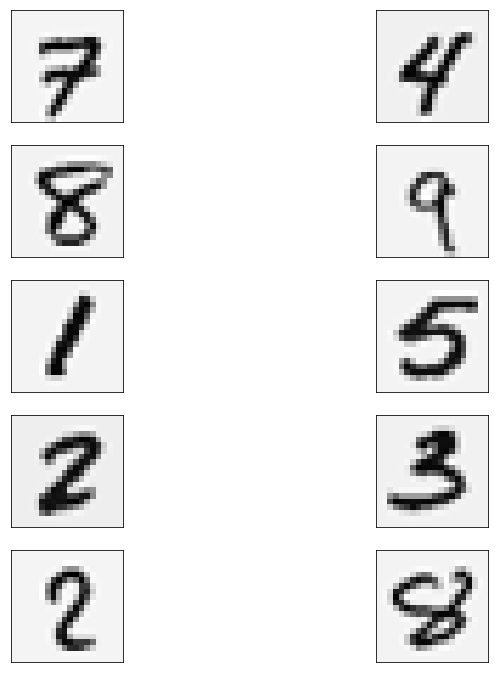

In [5]:
fig, ax_array = plt.subplots(nrows=5, ncols=2, sharey=True, sharex=True, figsize=(12, 12))#sharex就是所以子图共用xy轴
for r in range(5):
    for c in range(2):
        ax_array[r, c].matshow(np.array(sample_images[2 * r + c].reshape((20, 20))).T,cmap=matplotlib.cm.binary) #要加T 否则就是横这的图片哦
        plt.xticks(np.array([])) # 不显示xy轴
        plt.yticks(np.array([])) 

In [87]:
# 逻辑回归向量化 因为有10个类别 所以要训练10个逻辑回归训练分类器 向量化可以提高训练效率
#1. sigmoid 函数 
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [152]:
#2. 代价函数
def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / len(X) + reg

In [153]:
#向量正则化逻辑回归
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)
    
    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    
    return np.array(grad).ravel()

In [154]:
# 一对多分类器 k个类别就有k个分类器 每个分类器分是i和不是i
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    # k * (n + 1) array for the parameters of each of the k classifiers
    all_theta = np.zeros((num_labels, params + 1))
    
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    return all_theta

In [155]:
#检查输入的矩阵维度是否正确
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

In [156]:
np.unique(data['y']) #看一下有几类标签

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [157]:
all_theta = one_vs_all(data['X'],data['y'],10,1)
all_theta.shape

(10, 401)

In [158]:
def predict_all(X,all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]

    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)

    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1 # h的索引从0开始 但是我们的label从1开始 所以要+1
    
    return h_argmax

In [159]:
y_pred = predict_all(data['X'], all_theta)
print(classification_report(data['y'],y_pred,))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



In [135]:
#神经网络 在现有的权重基础上 实现前反馈神经网络
#25个隐层单元 和 10 个输出单元（10个分类）
weight = loadmat(r'data_sets\ex3weights.mat')
theta1,theta2 = weight['Theta1'],weight['Theta2']
theta1.shape,theta2.shape #1为输入层到隐藏层的权重 2 为隐藏层到输出层的权重 j(j+1) *j+1

((25, 401), (10, 26))

In [136]:
#插入常数项
X2 = np.matrix(np.insert(data['X'],0,values = np.ones(X.shape[0]),axis = 1))
y2 = np.matrix(data['y'])
X2.shape,y2.shape


((5000, 401), (5000, 1))

In [137]:
a1 = X2
z2 = X2 * theta1.T
z2.shape

(5000, 25)

In [138]:
a2 = sigmoid(z2)
a2.shape

(5000, 25)

In [139]:
a2 = np.insert(a2,0,values = np.ones(a2.shape[0]),axis = 1)
z3 = a2 * theta2.T
z3.shape

(5000, 10)

In [140]:
a3 = sigmoid(z3)
a3#(5000,10) 就是预测结果的列表

matrix([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
         4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
        [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
         2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
        [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
         6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
        ...,
        [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
         2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
        [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
         1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
        [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
         5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

In [141]:
y_pred2 = np.argmax(a3,axis=1) +1
y_pred2.shape


(5000, 1)

In [160]:
print(classification_report(data['y'],y_pred2))

              precision    recall  f1-score   support

           1       0.97      0.98      0.98       500
           2       0.98      0.97      0.98       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.97      0.98      0.98       500
           6       0.98      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

